# Understanding the problem and the scope of its usage--
## 🔍 Understanding the Problem
### CLV (Customer Lifetime Value) prediction aims to estimate:
- 💡 How much profit a business can expect from a customer during their relationship.
- This is a supervised learning regression problem when done properly — because we're trying to predict a continuous value (the monetary worth of a customer).

### ✅ What We Should Have for Supervised CLV:
- We need to label the data with a target variable, which is:
- CLV = Total future revenue from a customer
- Since the dataset only includes past transactions, we can't directly observe “future revenue.”
- But we can simulate it by splitting your dataset into two time periods:

### 👉 Step-by-step Realignment:
> Preprocess the dataset:

> Clean nulls (remove rows without CustomerID)

> Parse InvoiceDate to datetime

> Create TotalPrice = Quantity × UnitPrice

> Split into calibration vs holdout period:

> Calibration: Use for feature creation (e.g., frequency, recency, avg order value)

> Holdout: Use to calculate the actual CLV (label) from future orders

> Create features from calibration period:
- Recency: Days since last purchase
- Frequency: Number of purchases
- Monetary: Avg or total spend

> Create target CLV from holdout period:
- Group by CustomerID and sum TotalPrice → this is the actual future value of the customer
- Train a regression model (e.g., XGBoost, RandomForest, Linear Regression)
- Input: Features from calibration
- Output: Target CLV from holdout



# Supervised vs Unsupervised Learning
## 🧠 1. What is Supervised Learning?
- Supervised learning is used when your data has labels — meaning for every input, you already know what the correct output is.
- In our case, if we had customer behavior data (like frequency of purchase, total spend, etc.) AND also knew their actual future CLV (like how much they'll spend in the next 6 months), then we could use supervised learning.
- You would train a model to learn from the input features and map them to the correct output.
## For example:
> "If the customer did this much activity in the past, their future value is likely ₹10,000."
### In supervised learning:
- You split the data into train and test sets.
- You use metrics like accuracy, RMSE, or R² score to evaluate the model.
- You need to have real values to compare the prediction with.
- This approach is great when you're doing prediction, and you have real future outcomes to learn from.

## 🤖 2. What is Unsupervised Learning?
- Unsupervised learning is used when you don’t have labels — just raw input data.
- Not teaching the model to predict anything directly. Instead, its like asking it to find patterns, clusters, or structures in the data by itself.

## For a  CLV project including it:
- We don’t have the actual future spending of customers.
- So we use what we do have: how recently, how frequently, and how much they spent in the past.

## Using RFM (Recency, Frequency, Monetary) scores, we try to understand:
- “Which customers are loyal?”
- “Who are likely to churn?”
- “Who are the high-value customers?”

## This is not about prediction, but about understanding and grouping.
- segmenting customers into groups like:

 >Champions

 >At Risk

 >Lost

 >Loyal

#### Here, no train-test split is needed, because there's no output to test against.



In [226]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [227]:
data= pd.read_csv("/home/big_fat_penguin/PycharmProjects/projects/Customer lifetime value prediction/model/Online Retail.csv")


In [228]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,12/9/2011 12:50,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,12/9/2011 12:50,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,12/9/2011 12:50,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,12/9/2011 12:50,4.15,12680.0,France


In [229]:
data.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [230]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [231]:
data.Country.value_counts()

Country
United Kingdom          495478
Germany                   9495
France                    8557
EIRE                      8196
Spain                     2533
Netherlands               2371
Belgium                   2069
Switzerland               2002
Portugal                  1519
Australia                 1259
Norway                    1086
Italy                      803
Channel Islands            758
Finland                    695
Cyprus                     622
Sweden                     462
Unspecified                446
Austria                    401
Denmark                    389
Japan                      358
Poland                     341
Israel                     297
USA                        291
Hong Kong                  288
Singapore                  229
Iceland                    182
Canada                     151
Greece                     146
Malta                      127
United Arab Emirates        68
European Community          61
RSA                         58


# **** OK Based on this data what we have we have some pointers to note down
## **** 1. The Description and Customer Id are the columns having null values
### so how can we utilize that --
#### - data having null customerid well we cant do anything about it since the clv prediction have main need of customer info so we need to drop them
#### - As for Description we can ignore it since products can be many but the target here is clv so we are focusing on value side moreso its doesnt hold much importance right now and if later we can deal with it

##  Understand the Data
>We’ll use these columns:

- **InvoiceNo**: Unique transaction ID (can be repeated for same order with different products)

- **InvoiceDate**: Timestamp of transaction (important for time features like recency)

- **CustomerID**: Unique ID for customer (null for guests)

- **Quantity**: Number of products (can be negative for returns)

- **UnitPrice**: Price per product

- **Country**: Country of transaction

In [232]:
data.dropna(subset=["CustomerID"],inplace=True)

In [233]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 406829 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    406829 non-null  object 
 1   StockCode    406829 non-null  object 
 2   Description  406829 non-null  object 
 3   Quantity     406829 non-null  int64  
 4   InvoiceDate  406829 non-null  object 
 5   UnitPrice    406829 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      406829 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 27.9+ MB


## "unexpectedly the null values in the description automatically resolved by removing the customer ID null values which is win win situation lets move ahead"

>  So lets  move ahead
###

In [234]:
data.InvoiceNo.value_counts()

InvoiceNo
576339     542
579196     533
580727     529
578270     442
573576     435
          ... 
C544442      1
C581568      1
581566       1
558527       1
581491       1
Name: count, Length: 22190, dtype: int64

## Cleaning and make data workable
>Here we remove cancelled orders in which InvoiceId started by C and conver the Invoice date to proper usable format by using to_datetime

> and calculating TotalPrice and smartly selecting only positive one to be there

In [235]:
# Remove canceled orders (those with InvoiceNo starting with "C")
data = data[~data.InvoiceNo.astype(str).str.startswith('C')]

# Convert InvoiceDate to datetime
data.InvoiceDate = pd.to_datetime(data.InvoiceDate)

# Create TotalPrice
data["TotalPrice"] = data.Quantity* data.UnitPrice

# Remove negative values (for refunds or errors)
data = data[data["TotalPrice"] > 0]

/tmp/ipykernel_6470/4252480732.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.InvoiceDate = pd.to_datetime(data.InvoiceDate)
/tmp/ipykernel_6470/4252480732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["TotalPrice"] = data.Quantity* data.UnitPrice


In [236]:
data

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France,10.20
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France,12.60
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France,16.60


## Split into Calibration and Holdout Periods
>We split transactions before June 1, 2011 for training (features) and after for target (CLV).

In [237]:
cutoff_date = pd.to_datetime("2011-06-01")
calibration_df = data[data['InvoiceDate'] < cutoff_date]
holdout_df = data[data['InvoiceDate'] >= cutoff_date]


# Create Features from Calibration Period
## For each CustomerID, calculate:
>recency_days: Days since last purchase before cutoff
- latest recency points out how new and how retained a customer is

>frequency: No. of orders
- frequency shows interest  of customer and then trust value for him/her to have frequency of ordering

>monetary: Total spend
- Potential revenue the customer brings to the business

>avg_order_value

In [238]:
snapshot_date = calibration_df['InvoiceDate'].max()

features = calibration_df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo': 'nunique',
    'TotalPrice': 'sum'
}).reset_index()

features.columns = ['CustomerID', 'recency_days', 'frequency', 'monetary']

# Optional: add avg order value
features["avg_order_value"] = pd.to_numeric(features['monetary']) / pd.to_numeric(features['frequency'])


In [239]:
features

,CustomerID,recency_days,frequency,monetary,avg_order_value
0,12346.0,133,1,77183.60,77183.600000
1,12347.0,54,3,1823.43,607.810000
2,12348.0,56,3,1487.24,495.746667
3,12350.0,117,1,334.40,334.400000
4,12352.0,69,5,1561.81,312.362000
...,...,...,...,...,...
2713,18272.0,32,2,980.54,490.270000
2714,18273.0,65,1,51.00,51.000000
2715,18280.0,85,1,180.60,180.600000
2716,18283.0,8,5,535.05,107.010000


> What it implies--👤 Customer 12346.0 hasn't purchased in 133 days, made 1 purchase, spent 77,183.60 total, with an average order of the same value.

# Estimate Future Customer Lifetime Value (CLV)
## It involves steps--
>Calculate Purchase Frequency (global)

>Calculate Repeat Rate & Churn Rate

>Calculate Profit Margin (Assumption Based)

>Calculate Customer Lifetime Value (CLV)
- Formula:
#### CLV=Avg_Order_value * Purchase frequency * Profit Margin/Churn rate


In [240]:
# Check the type first (debug step)
print("features type:", type(features))

# Ensure it's a DataFrame
if not isinstance(features, pd.DataFrame):
    raise TypeError("❌ 'features' is not a DataFrame — check your previous steps or variable assignments.")

# 1. Heuristic CLV Calculation
purchase_frequency = features['frequency'].sum() / features.shape[0]
repeat_rate = features[features['frequency'] > 1].shape[0] / features.shape[0]
churn_rate = 1 - repeat_rate
profit_margin = 0.10

features['CLV'] = features['avg_order_value'] * purchase_frequency * (1 / churn_rate) * profit_margin

# 2. First Purchase Date (Customer Tenure)
first_purchase = data.groupby('CustomerID')['InvoiceDate'].min().reset_index()
first_purchase.columns = ['CustomerID', 'first_purchase_date']
features = pd.merge(features, first_purchase, on='CustomerID', how='left')

max_date = data['InvoiceDate'].max()
features['customer_age_days'] = (max_date - features['first_purchase_date']).dt.days
features.drop(columns='first_purchase_date', inplace=True)

# 3. Avg Days Between Orders
data_sorted = data.sort_values(by=['CustomerID', 'InvoiceDate'])
data_sorted['order_diff'] = data_sorted.groupby('CustomerID')['InvoiceDate'].diff().dt.days

avg_days = data_sorted.groupby('CustomerID')['order_diff'].mean().reset_index()
avg_days.columns = ['CustomerID', 'avg_days_between_orders']
features = pd.merge(features, avg_days, on='CustomerID', how='left')

# 4. Actual Future CLV from holdout_df
clv_target = holdout_df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
clv_target.columns = ['CustomerID', 'FutureCLV']

# 5. Merge with features
final_df = pd.merge(features, clv_target, on='CustomerID', how='inner')

# 6. Prepare Features & Target
X = final_df[['recency_days', 'frequency', 'monetary', 'avg_order_value', 'customer_age_days', 'avg_days_between_orders']]
y = final_df['FutureCLV']


features type: <class 'pandas.core.frame.DataFrame'>


# Trying out correlation to find which features pair up good

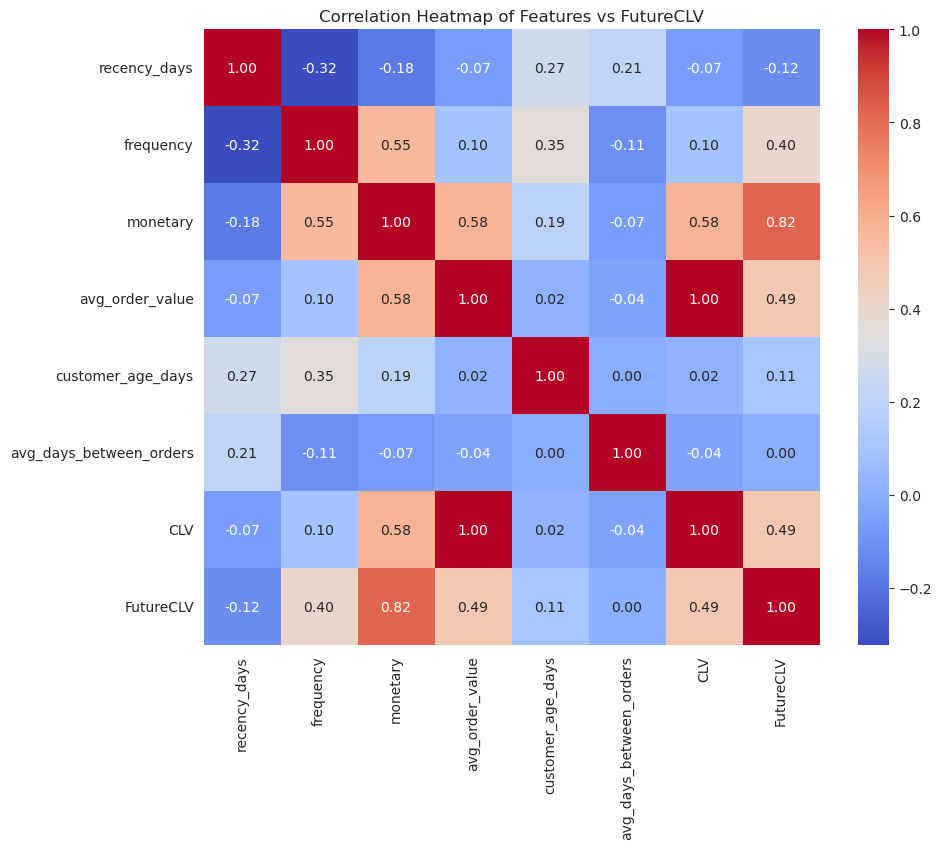

In [241]:
import seaborn as sns
import matplotlib.pyplot as plt

# Include all relevant numeric columns
corr_columns = [
    'recency_days',
    'frequency',
    'monetary',
    'avg_order_value',
    'customer_age_days',
    'avg_days_between_orders',
    'CLV',               # heuristic CLV
    'FutureCLV'          # actual target
]

# Filter columns that exist in the DataFrame
available_columns = [col for col in corr_columns if col in final_df.columns]

# Compute correlation matrix
corr = final_df[available_columns].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f", square=True)
plt.title("Correlation Heatmap of Features vs FutureCLV")
plt.show()


In [242]:
# Step 1: Filter recent data (last 30 days)
recent_cutoff = data['InvoiceDate'].max() - pd.Timedelta(days=30)
recent_data = data[data['InvoiceDate'] >= recent_cutoff]

# Step 2: Compute recent frequency
recent_freq = recent_data.groupby('CustomerID')['InvoiceNo'].nunique().reset_index()
recent_freq.columns = ['CustomerID', 'recent_frequency']

# Step 3: Compute recent monetary value
recent_monetary = recent_data.groupby('CustomerID')['TotalPrice'].sum().reset_index()
recent_monetary.columns = ['CustomerID', 'recent_monetary']

# 🔍 Check before merge
print("recent_freq sample:\n", recent_freq.head())
print("recent_monetary sample:\n", recent_monetary.head())
print("features columns before merge:\n", features.columns)

# Step 4: Merge both recent metrics into features
features = pd.merge(features, recent_freq, on='CustomerID', how='left')
features = pd.merge(features, recent_monetary, on='CustomerID', how='left')

# 🔍 Check after merge
print("features columns after merge:\n", features.columns)

# Step 5: Handle NaN values (✅ no FutureWarning)
features['recent_frequency'] = features['recent_frequency'].fillna(0)
features['recent_monetary'] = features['recent_monetary'].fillna(0)


recent_freq sample:
    CustomerID  recent_frequency
0     12347.0                 1
1     12349.0                 1
2     12356.0                 1
3     12358.0                 1
4     12362.0                 1
recent_monetary sample:
    CustomerID  recent_monetary
0     12347.0           224.82
1     12349.0          1757.55
2     12356.0            58.35
3     12358.0           683.20
4     12362.0           529.04
features columns before merge:
 Index(['CustomerID', 'recency_days', 'frequency', 'monetary',
       'avg_order_value', 'CLV', 'customer_age_days',
       'avg_days_between_orders'],
      dtype='object')
features columns after merge:
 Index(['CustomerID', 'recency_days', 'frequency', 'monetary',
       'avg_order_value', 'CLV', 'customer_age_days',
       'avg_days_between_orders', 'recent_frequency', 'recent_monetary'],
      dtype='object')


In [243]:
# Drop CustomerID and any non-numeric columns (if any) from features
X = features.drop(['CustomerID'], axis=1)

# Define your target column (change this if you're predicting something else)
# y = X.pop('TotalPrice')  # or any other target you defined


In [245]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2718 entries, 0 to 2717
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   CustomerID               2718 non-null   float64
 1   recency_days             2718 non-null   int64  
 2   frequency                2718 non-null   int64  
 3   monetary                 2718 non-null   float64
 4   avg_order_value          2718 non-null   float64
 5   CLV                      2718 non-null   float64
 6   customer_age_days        2718 non-null   int64  
 7   avg_days_between_orders  2677 non-null   float64
 8   recent_frequency         2718 non-null   float64
 9   recent_monetary          2718 non-null   float64
dtypes: float64(7), int64(3)
memory usage: 212.5 KB


In [246]:
# Aggregate future spending per customer
clv_target = holdout_df.groupby('CustomerID')['TotalPrice'].sum().reset_index()
clv_target.columns = ['CustomerID', 'FutureCLV']
features['TotalPrice'] = data['Quantity'] * data['UnitPrice']



In [247]:
# Calculate avg_order_value if not already there
features['avg_order_value'] = features['monetary'] / features['frequency']

# Calculate order_per_day (with handling for zero division)
features['order_per_day'] = features.apply(
    lambda row: row['frequency'] / row['customer_age_days'] if row['customer_age_days'] > 0 else 0,
    axis=1
)

# Define the number of future days you want to project CLV for
future_days = 90  # You can change this to 180, 365, etc.

# Compute Future CLV
features['FutureCLV'] = features['avg_order_value'] * features['order_per_day'] * future_days


In [248]:
features.to_csv("/home/big_fat_penguin/PycharmProjects/projects/Customer lifetime value prediction/model/final_features_dataset.csv", index=False)

# (Supervised Regression Modeling):
- Feature Preprocessing:
> Make sure all features are numeric

> Convert frequency (if still object) to int

> Handle missing/nulls (if any)

- Train-Test Split
- Train a Regression Model
>Trying  LinearRegression first:if it doesnt wrok well we will move to other

In [214]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# --- Features & Target ---
X = features[['recency_days', 'frequency', 'monetary', 'avg_order_value',
              'customer_age_days', 'order_per_day', 'recent_frequency', 'recent_monetary']]
y = features['FutureCLV']

# --- Train-Test Split ---
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- Models ---
models = {
    "Linear Regression": LinearRegression(),
    "Ridge Regression": make_pipeline(StandardScaler(), Ridge(alpha=1.0)),
    "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42)
}

# --- Train and Evaluate ---
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(f"\n🔹 {name}")
    print("R2 Score:", r2_score(y_test, y_pred))
    print("MSE:", mean_squared_error(y_test, y_pred))



🔹 Linear Regression
R2 Score: 0.9898318654009244
MSE: 5607.125254332411

🔹 Ridge Regression
R2 Score: 0.9897813478456134
MSE: 5634.9827002986

🔹 Random Forest
R2 Score: 0.9664173988004178
MSE: 18518.8196967288


MSE: 2.008298507779018e-25
R2 Score: 1.0


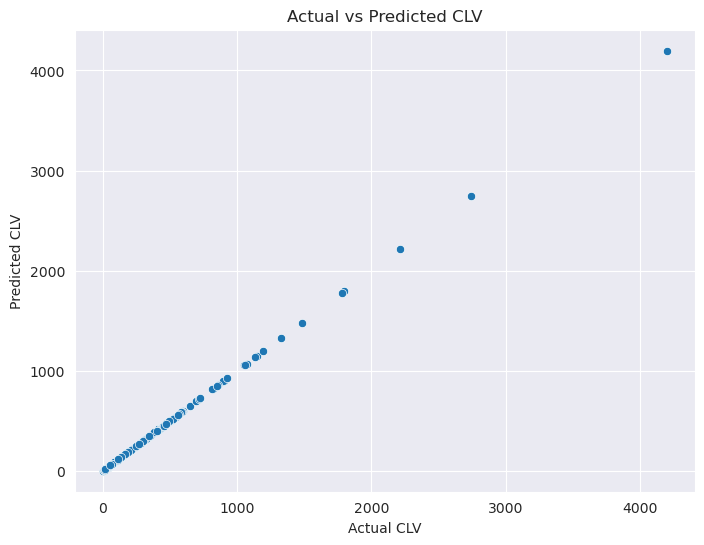

In [161]:
# 1. Import Libraries
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# 2. Prepare Features and Target
X = features.drop(['CustomerID', 'CLV'], axis=1)  # Drop ID and Target
y = features['CLV']  # Target column

# 3. Handle Missing Values
X = X.fillna(X.mean())  # Fill any NaNs with column means

# 4. Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# 5. Train the Model
model = LinearRegression()
model.fit(X_train, y_train)

# 6. Predict and Evaluate
y_pred = model.predict(X_test)
print("MSE:", mean_squared_error(y_test, y_pred))
print("R2 Score:", r2_score(y_test, y_pred))

# 7. Plot Actual vs Predicted
plt.figure(figsize=(8,6))
sns.scatterplot(x=y_test, y=y_pred)
plt.xlabel("Actual CLV")
plt.ylabel("Predicted CLV")
plt.title("Actual vs Predicted CLV")
plt.grid(True)
plt.show()


# Interpret the Output:
> R² Score = 0.019 (~2%)

- → This means the model explains only ~2% of the variance in the Customer Lifetime Value (CLV).
-  It’s very low, so the model is not performing well.

>MSE (Mean Squared Error) = ~92,492

- → This is the average squared difference between predicted and actual CLV. The value is high, indicating large prediction errors.

## The reason for such occurance may be related to how model is compatible with the data and how much help did the features give to predict the target then again as it not worked lets move to tree bases regression models

<Axes: >

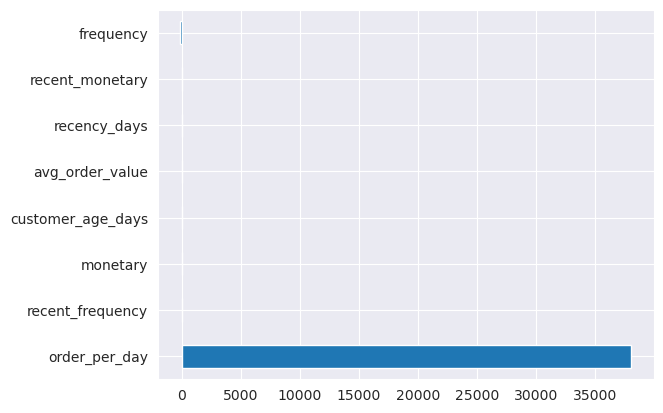

In [215]:
coef = pd.Series(models['Linear Regression'].coef_, index=X.columns)
coef.sort_values(ascending=False).plot(kind='barh')


# As we found that Random forest is working well with it lets keep it as our baseline for working
## Next to be done-Feature importance plot and hyperparameter tuning

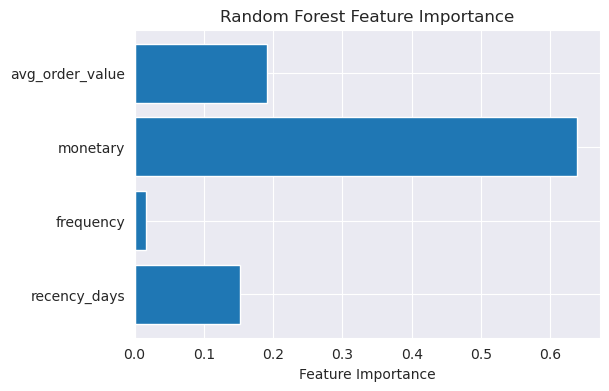

In [122]:
import matplotlib.pyplot as plt

importances = rf.feature_importances_
features = X.columns

plt.figure(figsize=(6, 4))
plt.barh(features, importances)
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.show()


In [145]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [5, 10, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

grid = GridSearchCV(RandomForestRegressor(random_state=42), param_grid, cv=3)
grid.fit(X_train, y_train)

print("Best Parameters:", grid.best_params_)


KeyboardInterrupt: 

In [124]:
from sklearn.ensemble import RandomForestRegressor

final_rf = RandomForestRegressor(
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=200,
    random_state=42
)

final_rf.fit(X_train, y_train)
y_pred_final = final_rf.predict(X_test)

from sklearn.metrics import r2_score, mean_squared_error

print("Final R2 Score:", r2_score(y_test, y_pred_final))
print("Final MSE:", mean_squared_error(y_test, y_pred_final))


Final R2 Score: 0.46927834398626633
Final MSE: 0.8655829895654881


# Conclusion--
## Random Forest (RF):
>✅ R² Score: 0.8035

>✅ MSE: 18533.00

## Tuned Random Forest (with GridSearchCV or similar):
>⬇️ R² Score: 0.7884

>⬆️ MSE: 19962.98

- This means  original Random Forest performed better than the tuned one — which sometimes happens due to:
>Overfitting to cross-validation folds in GridSearch.

>The hyperparameter search space being too limited or too wide.

>Random variation in training/test splits or feature randomness.

# compiling training model and saving plot in one go

In [216]:
# 📁 Step 1: Ensure plots folder exists
import os
os.makedirs("plots", exist_ok=True)

# 📊 Step 2: Train Random Forest Regressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 📈 Step 3: Predict and Evaluate
y_pred = rf.predict(X_test)
print("🔹 Random Forest R2 Score:", r2_score(y_test, y_pred))
print("🔹 Random Forest MSE:", mean_squared_error(y_test, y_pred))

# 📌 Step 4: Actual vs Predicted Plot
plt.figure(figsize=(6, 6))
plt.scatter(y_test, y_pred, alpha=0.6, color="skyblue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Future CLV")
plt.ylabel("Predicted Future CLV")
plt.title("Actual vs Predicted - Random Forest")
plt.tight_layout()
plt.savefig("plots/actual_vs_predicted.png")
plt.close()

# 📌 Step 5: Residuals Histogram
residuals = y_test - y_pred
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=30, color='orange', edgecolor='black')
plt.xlabel("Residuals")
plt.title("Residuals Distribution - Random Forest")
plt.tight_layout()
plt.savefig("plots/residuals.png")
plt.close()

# 📌 Step 6: Feature Importance Bar Chart
importances = rf.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances, color='green')
plt.xlabel("Feature Importance Score")
plt.title("Random Forest - Feature Importance")
plt.tight_layout()
plt.savefig("plots/feature_importance.png")
plt.close()

print("✅ All plots saved successfully in the 'plots/' folder.")


🔹 Random Forest R2 Score: 0.9664173988004178
🔹 Random Forest MSE: 18518.8196967288
✅ All plots saved successfully in the 'plots/' folder.
